#### Quick look at the data

In [2]:
import numpy as np 
import matplotlib as mpl
import matplotlib.pyplot as plt
import xarray as xr
import geopandas
# from argopy import DataFetcher as ArgoDataFetcher
import gsw

In [3]:
plt.rc('font', size=12)

### Argo data

Tried to load in some Argo data to have a look at but this method did not seem to work.

In [14]:
argo_loader = ArgoDataFetcher()
latmin, latmax = -60, -45
lonmin, lonmax = -180, 180
pressure_min, pressure_max = 0, 10

In [33]:
# ds_argo = argo_loader.region([lonmin, lonmax, latmin, latmax, pressure_min, pressure_max, '2019-01', '2019-02']).to_xarray()

### Saildrone data

Circumpolar track around the Southern Ocean from 2019.

In [4]:
# TO DO: Upload ADCP data file and load that in too

In [5]:
file = '~/OHW22_proj_front_finder/data/saildrones/saildrone-gen_5-antarctica_circumnavigation_2019-sd1020-20190119T040000-20190803T043000-1440_minutes-v1.1620361814756.nc'

In [6]:
ds_saildrone = xr.open_dataset(file)

In [19]:
variables = [
    'TEMP_CTD_RBR_STDDEV',
    'TEMP_CTD_RBR_MEAN',
    'SAL_RBR_MEAN',
    'SAL_RBR_STDDEV',
    'O2_CONC_AANDERAA_MEAN',
    'O2_CONC_AANDERAA_STDDEV',
    'CHLOR_RBR_MEAN',
    'CHLOR_RBR_STDDEV']

subset_saildrone = ds_saildrone[variables]

# How are these variables calculated? Mean/sstdev of the top few m??

In [20]:
subset_saildrone = subset_saildrone.isel(trajectory = 0)
df = subset_saildrone.to_dataframe()

In [31]:
def distFromStart(latitude, longitude):
    '''Cumulative distance from the first profile (km)'''

    dist_between_points = np.concatenate((np.array([0]), gsw.distance(longitude, latitude)))
    dist_between_points_km = dist_between_profiles/1000
    dist_from_start = np.nancumsum(dist_between_profiles_km)
    
    return dist_from_start

In [26]:
distance = distFromStart(df.latitude.values, df.longitude.values)

In [28]:
df['distance_km'] = distance

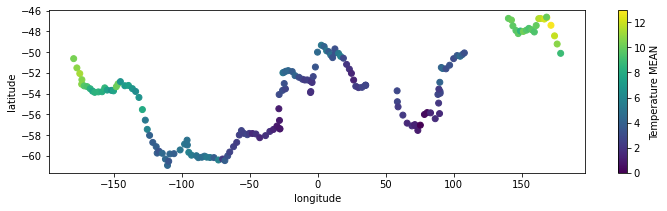

In [27]:
fig, ax = plt.subplots(figsize = (12,3))
plt.scatter(df.longitude, df.latitude, c = df.TEMP_CTD_RBR_MEAN, vmin = 0, vmax = 13)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.colorbar(label = 'Temperature MEAN')

# TO DO: add ADT contours and plot trajectory of saildrone on a map 

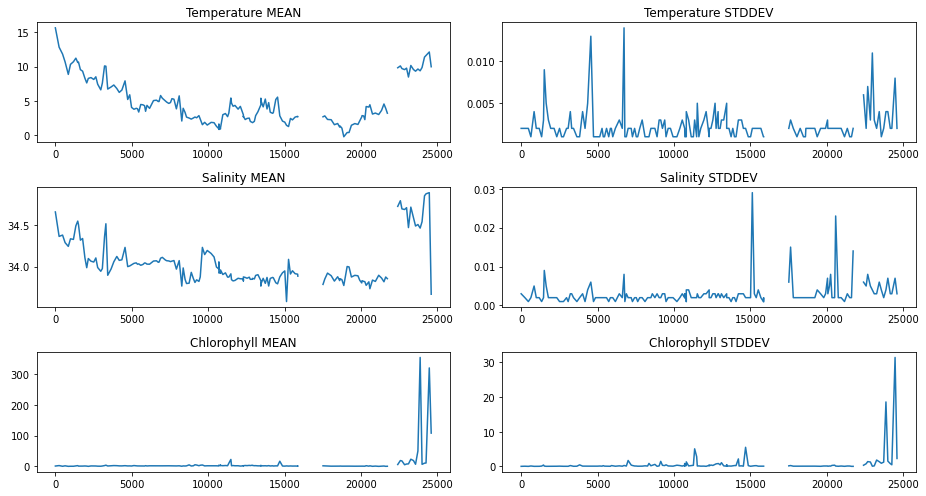

In [30]:
# Some timeseries plots to have a look at the data 
x = df.time
x = df.distance_km

fig, axs = plt.subplots(3, 2, figsize = (13,7))
axs = axs.flatten()

axs[0].plot(x, df.TEMP_CTD_RBR_MEAN)
axs[0].set_title('Temperature MEAN')

axs[1].plot(x, df.TEMP_CTD_RBR_STDDEV)
axs[1].set_title('Temperature STDDEV')

axs[2].plot(x, df.SAL_RBR_MEAN)
axs[2].set_title('Salinity MEAN')

axs[3].plot(x, df.SAL_RBR_STDDEV)
axs[3].set_title('Salinity STDDEV')

axs[4].plot(x, df.CHLOR_RBR_MEAN)
axs[4].set_title('Chlorophyll MEAN')

axs[5].plot(x, df.CHLOR_RBR_STDDEV)
axs[5].set_title('Chlorophyll STDDEV')

plt.tight_layout(h_pad = 1.2)